In [ ]:
# See E. Peterfreund, O. Lindenbaum, F. Dietrich, T. Bertalan, M. Gavish, I.G. Kevrekidis and R.R. Coifman,
# "LOCA: LOcal Conformal Autoencoder for standardized data coordinates",
# https://www.pnas.org/doi/full/10.1073/pnas.2014627117
#
#
# -----------------------------------------------------------------------------
# Author: Erez Peterfreund , Ofir Lindenbaum
#         erezpeter@gmail.com  , ofir.lindenbaum@yale.edu , 2020
# 
# This program is free software: you can redistribute it and/or modify it under
# the terms of the GNU General Public License as published by the Free Software
# Foundation, either version 3 of the License, or (at your option) any later
# version.
#
# This program is distributed in the hope that it will be useful, but WITHOUT
# ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS
# FOR A PARTICULAR PURPOSE.  See the GNU General Public License for more
# details.
#
# You should have received a copy of the GNU General Public License along with
# this program.  If not, see <http://www.gnu.org/licenses/>.
# -----------------------------------------------------------------------------

In [2]:
# import necessary packages 
import scipy

import numpy as np
import matplotlib.pyplot as plt
from utils import *
from Loca import *


# Load original grid and preprocessed points found on the paper

In [84]:
orig_clouds=np.load('Experiment_7A_latent_space.npy')
data_in=np.load('Experiment_7A_ambient_space.npy')

# Extract clouds from the picture

#  1. Cluster the points

In [4]:
# Subsample data
N=2500

permute=np.random.permutation(data_in.shape[0])
data_subsample=data_in[permute,:][:N*2000,:]

In [7]:
# Cluster the points using DBScan
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.002, min_samples=30).fit(data_subsample)


array([   0,    1,    2, ...,   48,  272, 1655])

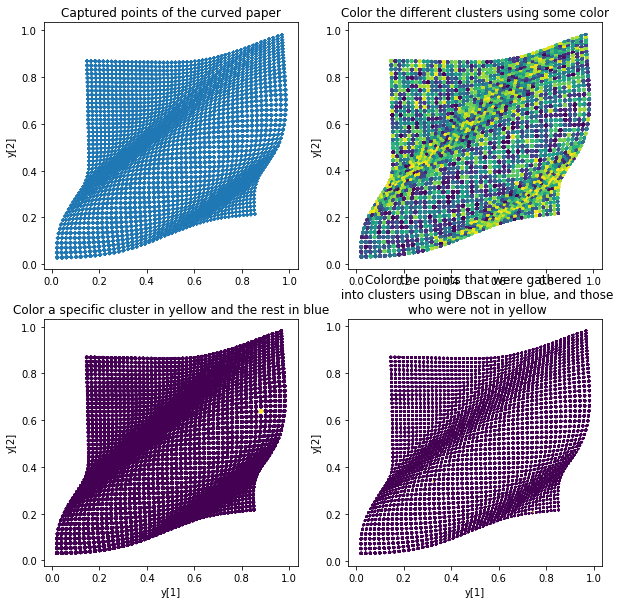

In [81]:
f,ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].scatter(data_subsample[:,0],data_subsample[:,1],s=0.1)
ax[0,0].set_title('Captured points of the curved paper')

myind= np.where(clustering.labels_>-1)[0]
ax[0,1].scatter(data_subsample[myind,0],data_subsample[myind,1],c=clustering.labels_[myind],s=1)
ax[0,1].set_title('Color the different clusters using some color')

ax[1,0].scatter(data_subsample[:,0],data_subsample[:,1],c=clustering.labels_==2,s=1)
ax[1,0].set_title('Color a specific cluster in yellow and the rest in blue')


ax[1,1].scatter(data_subsample[:,0],data_subsample[:,1],c=clustering.labels_==-1,s=0.1)
ax[1,1].set_title('Color the points that were gathered \n into clusters using DBscan in blue, and those\n who were not in yellow')


for i in range(2):
    for j in range(2):
        if i>0:
            ax[i,j].set_xlabel('y[1]')
        ax[i,j].set_ylabel('y[2]')

Text(0,0.5,'Amount of points')

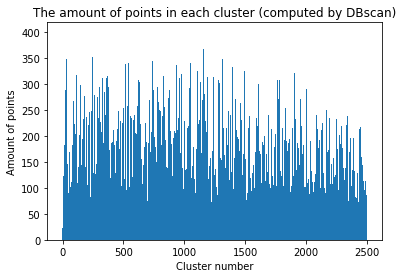

In [49]:
hist = plt.hist(clustering.labels_,bins=np.unique(clustering.labels_))
plt.title('The amount of points in each cluster (computed by DBscan)')
plt.xlabel('Cluster number')
plt.ylabel('Amount of points')

# 2. Subsample each cluster and define it as a burst 

In [50]:
M=60
additionalDataY_est=np.zeros((N,M,2))
y_est=np.zeros((N,2))
for i in range(0,N):
    additionalDataY_est[i,:,:]=data_subsample[np.where(clustering.labels_==i),:][0,:M,:]
    y_est[i,:]=np.mean(additionalDataY_est[i,:,:],axis=0)


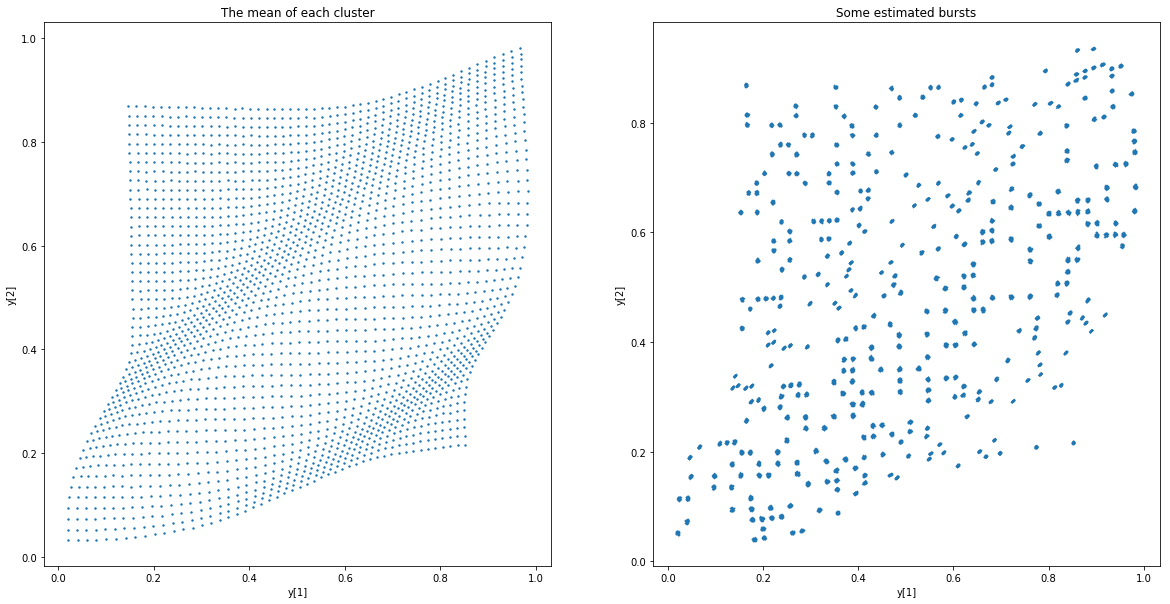

In [55]:
f,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].scatter(y_est[:,0],y_est[:,1],s=2)
ax[0].set_title('The mean of each cluster')

ax[1].scatter(additionalDataY_est[:400,:,0],additionalDataY_est[:400,:,1],s=0.2)
ax[1].set_title('Some estimated bursts')

for i in range(2):
    ax[i].set_xlabel('y[1]')
    ax[i].set_ylabel('y[2]')


# 3. Divide data into train and test, and estimate cloud_std
# that is close to the covariances of the bursts

In [56]:
# Divide into train and validation
indexes = np.random.permutation(N)
indexes_train, indexes_val = indexes[:N*9//10], indexes[N*9//10:]

data_train = additionalDataY_est[indexes_train,:,:]
data_val = additionalDataY_est[indexes_val,:,:]

In [57]:
# Estimate the covariances of the different estimated bursts and their eigenvalues.
# Estimate the median of the leading eigenvalue across all bursts and use it as the standard deviation
# of the burst in LOCA.
eigs = np.zeros((N,2))
for i in range(N):
    eigs[i,:]= np.linalg.eig(np.cov(additionalDataY_est[i,:,:].T))[0]
    
np.median(eigs[:,0])

3.660811558624555e-06

# Define and train the neural net

In [28]:
amount_epochs = 20000
cloud_std=np.sqrt(3e-06)

params = {}
params['clouds_var']= cloud_std**2 

params['activation_enc']='tanh' # The activation function defined in the encoder
#Options: 'relu'- Relu,   'l_relu'- Leaky Relu,    'sigmoid'-sigmoid,   'tanh'- tanh, 'none'- none
params['activation_dec']='l_relu' # The activation function defined in the decoder

params['encoder_layers']=[2,100,100,100,2,2] # The amount of neurons in each layer of the encoder 
params['decoder_layers']=[2,100,100,100,2,2] # The amount of neurons in each layer of the decoder 

model = Loca(**params) 


In [26]:
N*.9

2250.0

In [30]:
batch_size=250
lrs= [1e-3,3e-4,1e-4]


model = Loca(**params) 

for lr in lrs:
    model.train( data_train,amount_epochs,lr=lr, batch_size=batch_size, data_val=data_val, evaluate_every=100,verbose=True)

Epoch: 0100 Train : white= 1.08739 rec=0.04047      Val: : white= 1.08497 rec=0.03756
Epoch: 0200 Train : white= 1.07624 rec=0.03944      Val: : white= 1.07428 rec=0.03646
Epoch: 0300 Train : white= 1.06989 rec=0.03953      Val: : white= 1.06914 rec=0.03652
Epoch: 0400 Train : white= 1.06436 rec=0.03963      Val: : white= 1.06319 rec=0.03660
Epoch: 0500 Train : white= 1.05920 rec=0.03990      Val: : white= 1.05743 rec=0.03685
Epoch: 0600 Train : white= 1.05508 rec=0.03978      Val: : white= 1.05458 rec=0.03674
Epoch: 0700 Train : white= 1.05173 rec=0.04002      Val: : white= 1.05061 rec=0.03696
Epoch: 0800 Train : white= 1.04417 rec=0.04016      Val: : white= 1.04196 rec=0.03709
Epoch: 0900 Train : white= 1.04027 rec=0.04006      Val: : white= 1.03657 rec=0.03700
Epoch: 1000 Train : white= 1.03892 rec=0.03977      Val: : white= 1.03492 rec=0.03671
Epoch: 1100 Train : white= 1.03766 rec=0.04003      Val: : white= 1.03288 rec=0.03696
Epoch: 1200 Train : white= 1.03375 rec=0.04066      Va

Epoch: 9700 Train : white= 0.06607 rec=0.00004      Val: : white= 0.06357 rec=0.00004
Epoch: 9800 Train : white= 0.06900 rec=0.00017      Val: : white= 0.06682 rec=0.00018
Epoch: 9900 Train : white= 0.06769 rec=0.00004      Val: : white= 0.06508 rec=0.00004
Epoch: 10000 Train : white= 0.06935 rec=0.00004      Val: : white= 0.06653 rec=0.00005
Epoch: 10100 Train : white= 0.06838 rec=0.00005      Val: : white= 0.06624 rec=0.00005
Epoch: 10200 Train : white= 0.06784 rec=0.00005      Val: : white= 0.06494 rec=0.00005
Epoch: 10300 Train : white= 0.06818 rec=0.00003      Val: : white= 0.06503 rec=0.00003
Epoch: 10400 Train : white= 0.06795 rec=0.00002      Val: : white= 0.06488 rec=0.00002
Epoch: 10500 Train : white= 0.06845 rec=0.00002      Val: : white= 0.06616 rec=0.00003
Epoch: 10600 Train : white= 0.07218 rec=0.00021      Val: : white= 0.06863 rec=0.00022
Epoch: 10700 Train : white= 0.06686 rec=0.00009      Val: : white= 0.06359 rec=0.00009
Epoch: 10800 Train : white= 0.06625 rec=0.0000

Epoch: 19200 Train : white= 0.06356 rec=0.00006      Val: : white= 0.06330 rec=0.00006
Epoch: 19300 Train : white= 0.06410 rec=0.00008      Val: : white= 0.06419 rec=0.00008
Epoch: 19400 Train : white= 0.06306 rec=0.00009      Val: : white= 0.06159 rec=0.00008
Epoch: 19500 Train : white= 0.06304 rec=0.00015      Val: : white= 0.06216 rec=0.00016
Epoch: 19600 Train : white= 0.06259 rec=0.00010      Val: : white= 0.06270 rec=0.00011
Epoch: 19700 Train : white= 0.06310 rec=0.00007      Val: : white= 0.06246 rec=0.00008
Epoch: 19800 Train : white= 0.06282 rec=0.00006      Val: : white= 0.06275 rec=0.00006
Epoch: 19900 Train : white= 0.06382 rec=0.00006      Val: : white= 0.06182 rec=0.00006
Epoch: 20000 Train : white= 0.06329 rec=0.00007      Val: : white= 0.06304 rec=0.00007
Epoch: 20100 Train : white= 0.06158 rec=0.00000      Val: : white= 0.05997 rec=0.00000
Epoch: 20200 Train : white= 0.06140 rec=0.00003      Val: : white= 0.05974 rec=0.00003
Epoch: 20300 Train : white= 0.06152 rec=0.0

Epoch: 28700 Train : white= 0.06057 rec=0.00000      Val: : white= 0.05889 rec=0.00000
Epoch: 28800 Train : white= 0.06089 rec=0.00000      Val: : white= 0.05920 rec=0.00000
Epoch: 28900 Train : white= 0.06073 rec=0.00000      Val: : white= 0.05910 rec=0.00000
Epoch: 29000 Train : white= 0.06112 rec=0.00000      Val: : white= 0.05944 rec=0.00001
Epoch: 29100 Train : white= 0.06090 rec=0.00001      Val: : white= 0.05931 rec=0.00001
Epoch: 29200 Train : white= 0.06087 rec=0.00001      Val: : white= 0.05952 rec=0.00001
Epoch: 29300 Train : white= 0.06067 rec=0.00001      Val: : white= 0.05932 rec=0.00001
Epoch: 29400 Train : white= 0.06095 rec=0.00001      Val: : white= 0.05955 rec=0.00001
Epoch: 29500 Train : white= 0.06085 rec=0.00000      Val: : white= 0.05947 rec=0.00000
Epoch: 29600 Train : white= 0.06083 rec=0.00000      Val: : white= 0.05929 rec=0.00000
Epoch: 29700 Train : white= 0.06095 rec=0.00000      Val: : white= 0.05932 rec=0.00000
Epoch: 29800 Train : white= 0.06043 rec=0.0

Epoch: 38200 Train : white= 0.05998 rec=0.00000      Val: : white= 0.05905 rec=0.00000
Epoch: 38300 Train : white= 0.05998 rec=0.00000      Val: : white= 0.05900 rec=0.00000
Epoch: 38400 Train : white= 0.06012 rec=0.00001      Val: : white= 0.05917 rec=0.00001
Epoch: 38500 Train : white= 0.06017 rec=0.00001      Val: : white= 0.05923 rec=0.00001
Epoch: 38600 Train : white= 0.06014 rec=0.00001      Val: : white= 0.05929 rec=0.00001
Epoch: 38700 Train : white= 0.06001 rec=0.00002      Val: : white= 0.05919 rec=0.00002
Epoch: 38800 Train : white= 0.05997 rec=0.00000      Val: : white= 0.05935 rec=0.00000
Epoch: 38900 Train : white= 0.06001 rec=0.00001      Val: : white= 0.05949 rec=0.00001
Epoch: 39000 Train : white= 0.06007 rec=0.00001      Val: : white= 0.05964 rec=0.00001
Epoch: 39100 Train : white= 0.06005 rec=0.00002      Val: : white= 0.05967 rec=0.00002
Epoch: 39200 Train : white= 0.05983 rec=0.00000      Val: : white= 0.05964 rec=0.00000
Epoch: 39300 Train : white= 0.06004 rec=0.0

Epoch: 47700 Train : white= 0.05936 rec=0.00000      Val: : white= 0.05847 rec=0.00000
Epoch: 47800 Train : white= 0.05936 rec=0.00000      Val: : white= 0.05853 rec=0.00000
Epoch: 47900 Train : white= 0.05936 rec=0.00000      Val: : white= 0.05851 rec=0.00000
Epoch: 48000 Train : white= 0.05934 rec=0.00000      Val: : white= 0.05854 rec=0.00000
Epoch: 48100 Train : white= 0.05934 rec=0.00000      Val: : white= 0.05847 rec=0.00000
Epoch: 48200 Train : white= 0.05934 rec=0.00000      Val: : white= 0.05854 rec=0.00000
Epoch: 48300 Train : white= 0.05934 rec=0.00000      Val: : white= 0.05845 rec=0.00000
Epoch: 48400 Train : white= 0.05934 rec=0.00000      Val: : white= 0.05853 rec=0.00000
Epoch: 48500 Train : white= 0.05933 rec=0.00000      Val: : white= 0.05856 rec=0.00000
Epoch: 48600 Train : white= 0.05934 rec=0.00000      Val: : white= 0.05855 rec=0.00000
Epoch: 48700 Train : white= 0.05933 rec=0.00000      Val: : white= 0.05857 rec=0.00000
Epoch: 48800 Train : white= 0.05932 rec=0.0

Epoch: 57200 Train : white= 0.05916 rec=0.00000      Val: : white= 0.05945 rec=0.00000
Epoch: 57300 Train : white= 0.05915 rec=0.00000      Val: : white= 0.05945 rec=0.00000
Epoch: 57400 Train : white= 0.05914 rec=0.00000      Val: : white= 0.05949 rec=0.00000
Epoch: 57500 Train : white= 0.05914 rec=0.00000      Val: : white= 0.05947 rec=0.00000
Epoch: 57600 Train : white= 0.05913 rec=0.00000      Val: : white= 0.05946 rec=0.00000
Epoch: 57700 Train : white= 0.05913 rec=0.00000      Val: : white= 0.05943 rec=0.00000
Epoch: 57800 Train : white= 0.05913 rec=0.00000      Val: : white= 0.05944 rec=0.00000
Epoch: 57900 Train : white= 0.05912 rec=0.00000      Val: : white= 0.05946 rec=0.00000
Epoch: 58000 Train : white= 0.05912 rec=0.00000      Val: : white= 0.05943 rec=0.00000
Epoch: 58100 Train : white= 0.05912 rec=0.00000      Val: : white= 0.05949 rec=0.00000
Epoch: 58200 Train : white= 0.05912 rec=0.00000      Val: : white= 0.05948 rec=0.00000
Epoch: 58300 Train : white= 0.05912 rec=0.0

In [59]:
embedding, _ =model.test(y_est)

# Calibrate the embedding with the original data- through the four corners of the grid

### Estimate the four corners in the latent and embedding space

In [62]:
# Estimate the four corners based on the points' 4th nearest neighbor in the embedding space
import scipy
dists= np.sort(scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(embedding)),axis=1)[:,4]
indxs= np.argsort(dists)[-4:]

# Sort them according to their angle with the x-axis
embedding_no_bias= embedding- np.mean(embedding,axis=0,keepdims=True)
indxs = indxs[np.argsort(np.arctan2(embedding_no_bias[indxs,1],embedding_no_bias[indxs,0]))]


# Do the same for the original grid of points
dists= np.sort(scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(orig_clouds)),axis=1)[:,4]
indxs_origin= np.argsort(dists)[-4:]
orig_clouds = orig_clouds-np.mean(orig_clouds,axis=0,keepdims=True)
indxs_origin = indxs_origin[np.argsort(np.arctan2(orig_clouds[indxs_origin,1],orig_clouds[indxs_origin,0]))]


Text(0,0.5,'$\\rho[2]$')

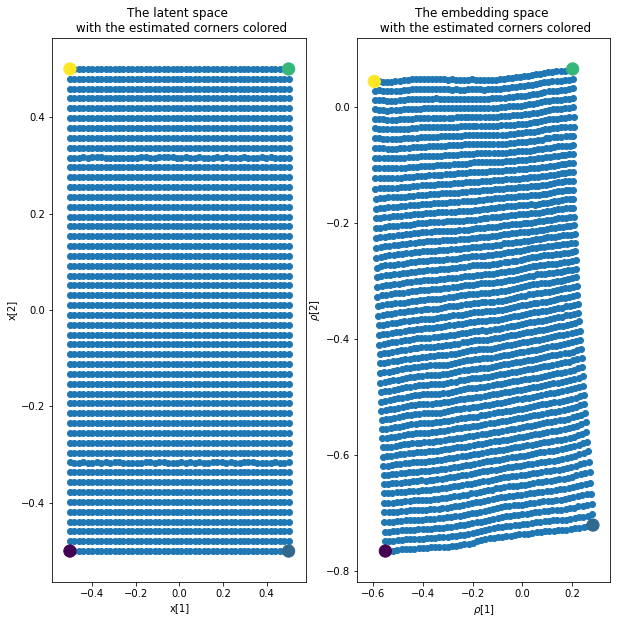

In [77]:

f,ax= plt.subplots(1,2,figsize=(10,10))
ax[0].scatter(orig_clouds[:,0],orig_clouds[:,1])
ax[0].scatter(orig_clouds[indxs_origin,0],orig_clouds[indxs_origin,1],c=[1,2,3,4],s=150)
ax[0].set_title('The latent space \n with the estimated corners colored')
ax[0].set_xlabel('x[1]')
ax[0].set_ylabel('x[2]')

ax[1].scatter(embedding[:,0],embedding[:,1])
ax[1].scatter(embedding[indxs,0],embedding[indxs,1],c=[1,2,3,4],s=150)
ax[1].set_title('The embedding space \n with the estimated corners colored')
ax[1].set_xlabel('$\\rho[1]$')
ax[1].set_ylabel('$\\rho[2]$')



### Calibrate the embedding based on these four corners 

In [70]:
R,bias, scaling= calibrate_data_b(orig_clouds[indxs_origin,:], embedding[indxs,:],scaling=True)

embedding_calibrated= scaling*np.matmul(embedding,R)+bias

# Fig 7b

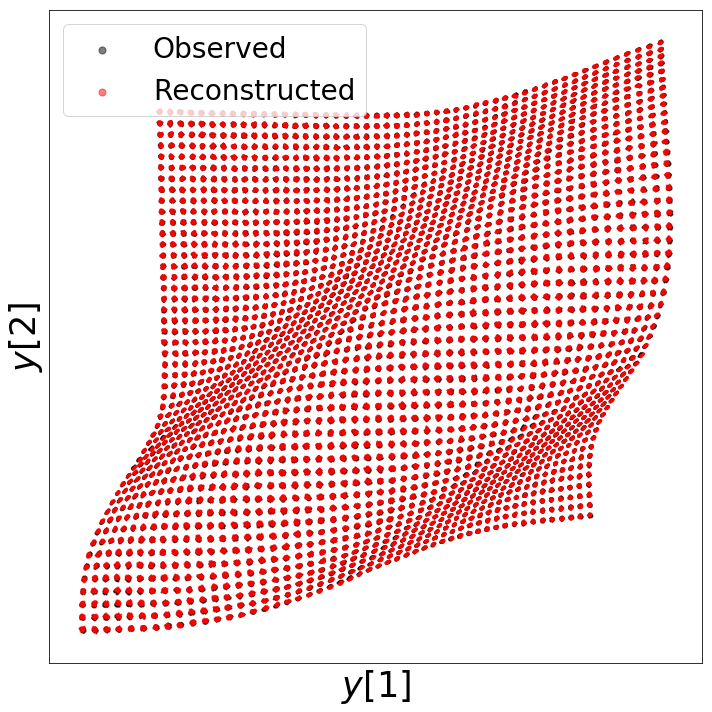

In [75]:
_, recon =model.test(additionalDataY_est)

f,ax = plt.subplots(1,1,figsize=(10,10))
plt.scatter(additionalDataY_est[:,:,0],additionalDataY_est[:,:,1],s=1,c='k',alpha=0.5,label='Observed')
plt.scatter(recon[:,:,0],recon[:,:,1],s=1,c='r',alpha=0.5,label='Reconstructed')
ax.set_xticks([])
ax.set_yticks([])
lgnd = plt.legend(fontsize=28,loc=2)
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
plt.xlabel('$y[1]$',fontsize=35)
plt.ylabel('$y[2]$',fontsize=35)
plt.tick_params(labelsize=20)
plt.tight_layout()


# Fig 7c

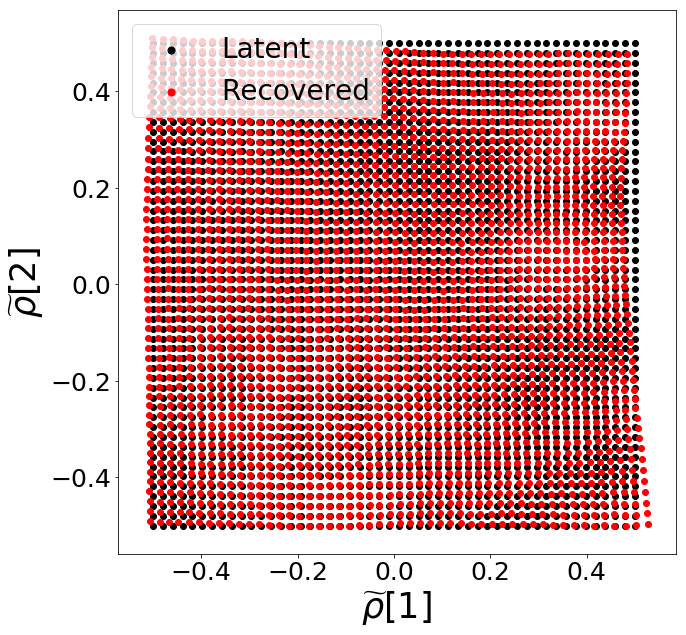

In [71]:
plt.figure(figsize=(10,10))
plt.scatter(orig_clouds[:,0],orig_clouds[:,1], label='Latent',c='k')
plt.scatter(embedding_calibrated[:,0],embedding_calibrated[:,1], label='Recovered',c='r')

lgnd = plt.legend(fontsize=28,loc=2)
lgnd.legendHandles[0]._sizes = [50]

lgnd.legendHandles[1]._sizes = [50]
plt.xlabel(r'$\widetilde{\rho}[1]$',fontsize=35)
plt.ylabel(r'$\widetilde{\rho}[2]$',fontsize=35)
plt.tick_params(labelsize=25)